In [1]:
    # Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Load and preprocess data (assuming data has been scaled in Part 2)
data = fetch_california_housing().data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [3]:
# Helper function to calculate Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [4]:
# K-Means from Scratch
class KMeansScratch:
    def __init__(self, n_clusters, max_iters=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels = None

    def fit(self, X):
        # Initialize centroids randomly from the data points
        np.random.seed(42)
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for i in range(self.max_iters):
            # Assign clusters
            self.labels = [self._closest_centroid(x) for x in X]
            
            # Calculate new centroids
            new_centroids = np.array([X[np.array(self.labels) == k].mean(axis=0) for k in range(self.n_clusters)])

            # Check for convergence
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids

        return self.labels

    def _closest_centroid(self, x):
        distances = [euclidean_distance(x, centroid) for centroid in self.centroids]
        return np.argmin(distances)

Silhouette Score for K=2: 0.33085466485216564
Silhouette Score for K=3: 0.2742620223797847
Silhouette Score for K=4: 0.27324735951239576
Silhouette Score for K=5: 0.25817215996925946

Optimal K from scratch: 2


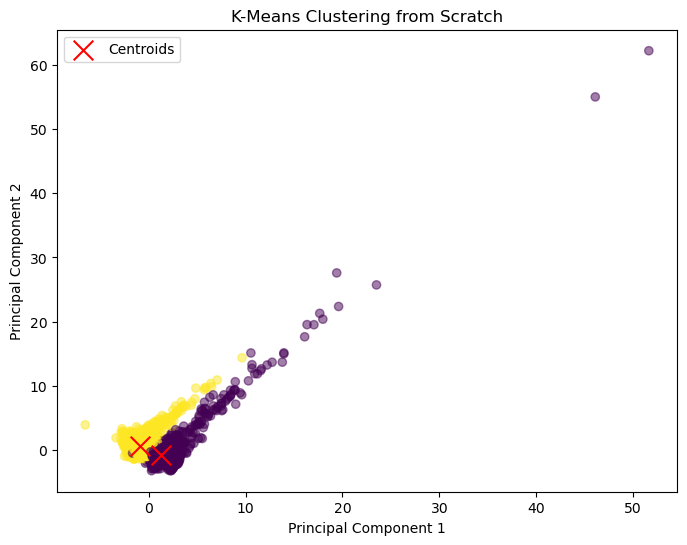

C:\Users\mayur\AppData\Local\Temp\ipykernel_12720\1354329559.py:28: RuntimeWarning: divide by zero encountered in log
  log_likelihood_new = np.sum(np.log(np.sum(self.responsibilities, axis=1)))
C:\Users\mayur\AppData\Local\Temp\ipykernel_12720\1354329559.py:29: RuntimeWarning: invalid value encountered in divide
  self.responsibilities /= self.responsibilities.sum(axis=1, keepdims=True)
C:\Users\mayur\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


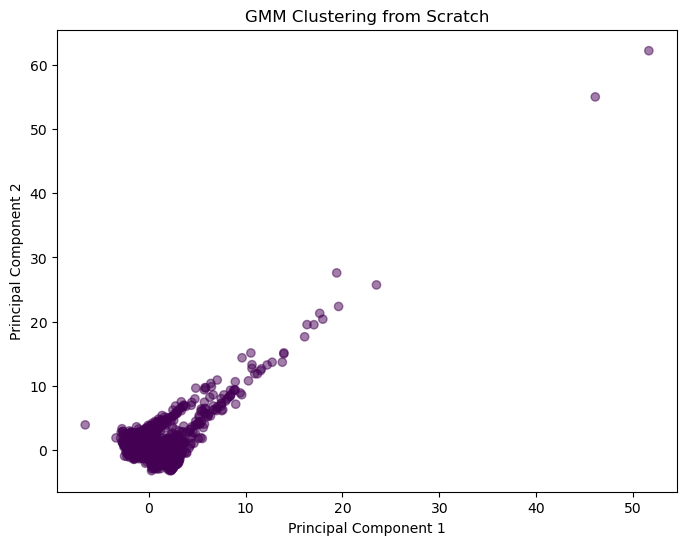

In [5]:
# Gaussian Mixture Model from Scratch
class GMMScratch:
    def __init__(self, n_components, max_iters=100, tol=1e-4):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None
        self.responsibilities = None

    def fit(self, X):
        np.random.seed(42)
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.cov(X, rowvar=False)] * self.n_components
        self.weights = np.full(self.n_components, 1 / self.n_components)

        log_likelihood = 0
        for _ in range(self.max_iters):
            # Expectation step
            self.responsibilities = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                self.responsibilities[:, k] = self.weights[k] * self._pdf(X, self.means[k], self.covariances[k])

            log_likelihood_new = np.sum(np.log(np.sum(self.responsibilities, axis=1)))
            self.responsibilities /= self.responsibilities.sum(axis=1, keepdims=True)

            # Check convergence
            if np.abs(log_likelihood_new - log_likelihood) < self.tol:
                break
            log_likelihood = log_likelihood_new

            # Maximization step
            Nk = self.responsibilities.sum(axis=0)
            self.weights = Nk / n_samples
            self.means = np.dot(self.responsibilities.T, X) / Nk[:, np.newaxis]
            self.covariances = [(np.dot((self.responsibilities[:, k][:, np.newaxis] * (X - self.means[k])).T, (X - self.means[k])) / Nk[k]) for k in range(self.n_components)]

        return np.argmax(self.responsibilities, axis=1)

    def _pdf(self, X, mean, cov):
        n_features = X.shape[1]
        det_cov = np.linalg.det(cov)
        norm_const = 1.0 / (np.power((2 * np.pi), n_features / 2) * np.sqrt(det_cov))
        X_centered = X - mean
        inv_cov = np.linalg.inv(cov)
        return norm_const * np.exp(-0.5 * np.sum(X_centered @ inv_cov * X_centered, axis=1))

# Determine Optimal Number of Clusters with Silhouette Score for K-Means
silhouette_scores = []
K_range = range(2, 6)  # Limit for simplicity

for k in K_range:
    kmeans_scratch = KMeansScratch(n_clusters=k)
    labels = kmeans_scratch.fit(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for K={k}: {score}")

# Optimal K from Silhouette Score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal K from scratch: {optimal_k}")

# Apply K-Means from Scratch with optimal K
kmeans_scratch = KMeansScratch(n_clusters=optimal_k)
kmeans_labels = kmeans_scratch.fit(data_scaled)
kmeans_centroids = kmeans_scratch.centroids

# Visualize K-Means Clustering Results
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.scatter(pca.transform(kmeans_centroids)[:, 0], pca.transform(kmeans_centroids)[:, 1],
            color='red', marker='x', s=200, label="Centroids")
plt.title("K-Means Clustering from Scratch")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Apply GMM from Scratch with optimal K
gmm_scratch = GMMScratch(n_components=optimal_k)
gmm_labels = gmm_scratch.fit(data_scaled)

# Visualize GMM Clustering Results
plt.figure(figsize=(8, 6))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=gmm_labels, cmap='viridis', alpha=0.5)
plt.title("GMM Clustering from Scratch")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [6]:
#Compairision 
# Import necessary libraries
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [7]:
# Step 1: Evaluate K-Means (from scratch) using Silhouette Score
kmeans_scratch = KMeansScratch(n_clusters=optimal_k)
kmeans_labels = kmeans_scratch.fit(data_scaled)
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

K-Means Silhouette Score: 0.33085466485216564


In [18]:
# Step 2: Evaluate GMM (from scratch) using Silhouette Score
gmm_scratch = GMMScratch(n_components=optimal_k)
gmm_labels = gmm_scratch.fit(data_scaled)
gmm_silhouette = silhouette_score(data_scaled, gmm_labels)
print(f"GMM Silhouette Score: {gmm_silhouette}")

C:\Users\mayur\AppData\Local\Temp\ipykernel_12720\1354329559.py:28: RuntimeWarning: divide by zero encountered in log
  log_likelihood_new = np.sum(np.log(np.sum(self.responsibilities, axis=1)))
C:\Users\mayur\AppData\Local\Temp\ipykernel_12720\1354329559.py:29: RuntimeWarning: invalid value encountered in divide
  self.responsibilities /= self.responsibilities.sum(axis=1, keepdims=True)
C:\Users\mayur\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)